In [1]:
import numpy as np
import numpy.random as rd
import matplotlib.pyplot as plt


1\. **Radioactive decay chain**

${\rm Tl}^{208}$ decays to ${\rm Pb}^{208}$ with a half-lieve of 3.052 minutes. Suppose to start with a sample of 1000 Thallium atoms and 0 of Lead atoms.

* Take steps in time of 1 second and at each time-step decide whether each Tl atom has decayed or not, accordingly to the probability $p(t)=1-2^{-t/\tau}$. Subtract the total number of Tl atoms that decayed at each step from the Tl sample and add them to the Lead one. Plot the evolution of the two sets as a function of time  
* Repeat the exercise by means of the inverse transform method: draw 1000 random numbers from the non-uniform probability distribution $p(t)=2^{-t/\tau}\frac{\ln 2}{\tau}$ to represent the times of decay of the 1000 Tl atoms. Make a plot showing the number of atoms that have not decayed as a function of time

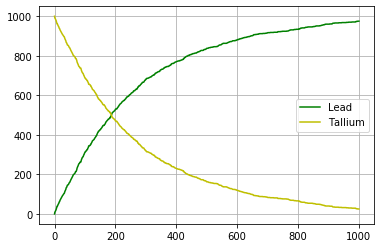

In [59]:
tau=3.052*60
Ntall=1000
nt=1000
t=np.linspace(0,1000,num=nt)
ntall=np.zeros(nt)
nlead=np.zeros(nt)
ntall[0]=Ntall
pt=1-2**(-t[1]/tau)

for i in range(1,nt):
    decayed=sum([rd.rand()<pt for j in range(int(ntall[i-1]))])
    ntall[i]=ntall[i-1]-decayed
    nlead[i]=decayed+nlead[i-1]
        
plt.plot(t,nlead,'g',label='Lead')
plt.plot(t,ntall,'y',label='Tallium')
plt.legend()
plt.grid()

plt.show()


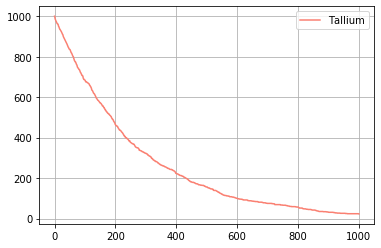

In [62]:
t_decay=np.sort(-tau*np.log2(1-rd.rand(Ntall)))
ntall=[1000-len(t_decay[t_decay<t[i]]) for i in range (len(t))]
plt.plot(t,ntall,color='salmon',label='Tallium')
plt.legend()
plt.grid()

2\. **Rutherford Scattering**

The scattering angle $\theta$ of $\alpha$ particles hitting a positively charged nucleus of a Gold atom ($Z=79$) follows the rule:

$$
\tan{\frac{1}{2} \theta} = \frac{Z e^2} {2\pi \epsilon_0 E b}
$$

where $E=7.7$ MeV and $b$ beam is the impact parameter. The beam is represented by a 2D gaussian distribution with $\sigma=a_0/100$ for both coordinates ($a_0$ being the Bohr radius). Assume 1 million $\alpha$ particles are shot on the gold atom.

Computing the fraction of particles that "bounce back",i.e. those particle whose scattering angle is greater than $\pi/2$ (which set a condition on the impact parameter $b$)

In [67]:
N=10**6
cost=79*1.602*10**(-19)/(2*np.pi*8.804*10**(-12)*7.7*10**6)
distr=cost/rd.normal(loc=0.0,scale=5.3*10**(-13),size=N)
print(distr)
print('The fraction of particles that gets bounced back is: ', len(distr[distr>1.0])/N )

[-0.07715759 -0.46264392 -0.10510915 ... -0.99841266  0.08247615
  0.34326186]
The fraction of particles that gets bounced back is:  0.022529


3\. **Monte Carlo integration: hit/miss vs mean value method**

Consider the function 

$$f(x) =\sin^2{\frac{1}{x(2-x)}}$$

* Compute the integral of $f(x)$ between 0 and 2 with the hit/miss method. Evaluate the error of your estimate
* Repeat the integral with the mean value method. Evaluate the error and compare it with the previous one

In [193]:
n=10000
def f(x):
    return np.sin(1/(x*(2-x)))**2
distx=rd.rand(n)*2
disty=rd.rand(n)
k=len(distx[disty<f(distx)])

print('the area, according to the hit/miss method is equal to', k*2/n)

the area, according to the hit/miss method is equal to 1.4444


In [194]:
print('the area, according to the mean value method, is equal to', 2/n*sum(f(distx)))

the area, according to the mean value method, is equal to 1.4544985736747076


4\. **Monte Carlo integration in high dimension**

* Start of by computing the area of a circle of unit radius, by integrating the function 

$$
f(x,y)=
\left\{
\begin{array}{ll}
      1 & x^2+y^2\le 1 \\
      0 & {\rm elsewhere}
\end{array} 
\right.
$$

* Generalize the result for a 10D sphere



In [23]:
N=1000000

X,Y=rd.rand(N),rd.rand(N)

k=0
for x,y in zip(X,Y):
    k+=((x**2+y**2)<=1)

print('the area of the 2D circle is: ',k/N)
print('The area should be: ', np.pi*0.25)

dimensions=10

X=np.array([rd.rand(N) for i in range(dimensions)])

k=0

for i in range(N):
    k+=(sum([x**2 for x in X[:,i]])<=1)

print('the area of the 10D sphere is: ',k/N)
print('The area should be: ', 0.5**10*np.pi**5/120)





the area of the 2D circle is:  0.786073
The area should be:  0.7853981633974483
the area of the 10D sphere is:  0.002393
The area should be:  0.00249039457019272


In [24]:
N=1000000

X,Y=rd.rand(N),rd.rand(N)

k=0
for x,y in zip(X,Y):
    if (x**2+y**2)<=1:
        k+=1

print('the area of the 2D circle is: ',k/N)
print('The area should be: ', np.pi*0.25)

dimensions=10

X=np.array([rd.rand(N) for i in range(dimensions)])

k=0

for i in range(N):
    if sum([x**2 for x in X[:,i]])<=1 :
        k+=1

print('the area of the 10D sphere is: ',k/N)
print('The area should be: ', 0.5**10*np.pi**5/120)

the area of the 2D circle is:  0.785654
The area should be:  0.7853981633974483
the area of the 10D sphere is:  0.002503
The area should be:  0.00249039457019272


5\. **Monte Carlo integration with importance sampling** 

Calculate the value of the integral:

$$
I=\int_0^1 \frac{x^{-1/2}}{e^x+1} dx
$$

using the importance sampling method with $w(x)=1/\sqrt{x}$. You should get a result about 0.84

In [44]:
def f(x):
    return 1/(np.sqrt(x)*(np.exp(x)+1))
N=1000000
x=rd.rand(N)

I=np.sum(f(x)*np.sqrt(x))*2/N


print(I)
#plt.plot(np.linspace(0,1,1000),1/np.sqrt(np.linspace(0,1,1000)))

0.7600111510112898


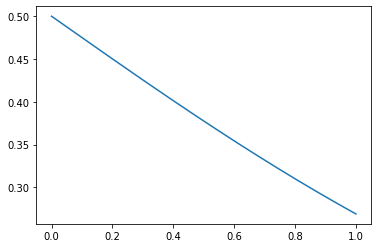

In [39]:
plt.plot(np.linspace(0.00000001,1,1000),f(np.linspace(0.00000001,1,1000))*np.sqrt(np.linspace(0.00000001,1,1000)))